In [63]:
import cira 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = "../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

SYMBOL = "ETH/USD" # MDRX is shortable 
SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

stk = cira.Stock(SYMBOL)

if not exists(SYM_HIST_FILE): # chacheing historical data  
    start = datetime(2015, 5, 1)
    end = datetime.now().date()
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2021-01-01 06:00:00+00:00,ETH/USD,742.15,745.00,716.65,733.65,6534.81013,6514.0,731.807780
2021-01-02 06:00:00+00:00,ETH/USD,735.29,791.08,725.44,786.88,16071.74933,15214.0,769.787732
2021-01-03 06:00:00+00:00,ETH/USD,786.64,1098.00,784.55,1086.86,44039.92386,43031.0,942.620484
2021-01-04 06:00:00+00:00,ETH/USD,1086.86,1169.05,880.00,991.40,50778.44556,51353.0,1030.893782
2021-01-05 06:00:00+00:00,ETH/USD,992.00,1138.00,980.08,1105.56,25283.79028,26369.0,1073.661942


<Axes: xlabel='timestamp'>

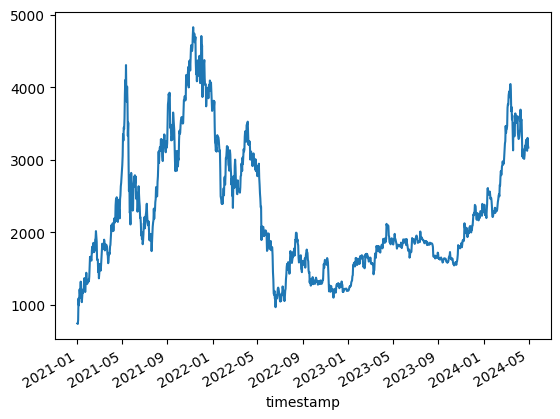

In [64]:
data["open"].plot()

In [65]:
data["sma"] = data["close"].rolling(window=20).mean() # simple moving avrage 
data["sd"] = data["close"].rolling(window=20).std()

data["ub"] = data["sma"] + 2 * data["sd"]
data["lb"] = data["sma"] - 2 * data["sd"]

<Axes: xlabel='timestamp'>

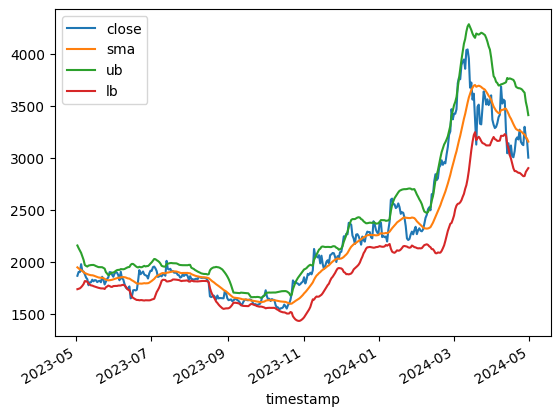

In [66]:
data.iloc[-365:][["close", "sma", "ub", "lb"]].plot()

In [67]:
split_prc = 0.8
train_data = data.iloc[:int(len(data)*split_prc)]
test_data =  data.iloc[int(len(data)*split_prc):]
print(len(data), len(train_data), len(test_data))
assert len(data) == len(train_data) + len(test_data)

1216 972 244


In [68]:
from numpy import ndarray
from pandas import DataFrame

from cira.strategy import back_test
from tqdm import tqdm


class BollingStartegy(cira.strategy.Strategy):

    def __init__(self, sma_window = 20, standard_deviation = 2, risk=0.1) -> None:
        super().__init__(name="Bolling")
        self.sma_window = sma_window
        self.standard_deviation = standard_deviation
        self.risk = risk 

    def iterate(self, feature_data: DataFrame, prices: DataFrame, portfolio: ndarray, cash:float)-> ndarray: 
        _feature_data = feature_data.copy()
        _feature_data["sma"] = _feature_data["open"].rolling(window=self.sma_window).mean() # simple moving avrage 
        _feature_data["sd"] =  _feature_data["open"].rolling(window=self.sma_window).std()

        _feature_data["ub"] =  _feature_data["sma"] + self.standard_deviation * _feature_data["sd"]
        _feature_data["lb"] =  _feature_data["sma"] - self.standard_deviation * _feature_data["sd"]

        if len(_feature_data) < self.sma_window:
            return np.array([0]).astype(float)

        if prices.iloc[-1].values[0] >= _feature_data.iloc[-1]["ub"]:
            return np.array([-1*portfolio[-1]]).astype(float)

        if prices.iloc[-1].values[0]>= _feature_data.iloc[-1]["lb"]:
            return np.array([int((cash*self.risk))//prices.iloc[-1].values[0]])

        return np.array([0]).astype(float)
                


    def fit(self, featrue_data: DataFrame, sma_windows = [10, 20, 30], standard_deviations = [1,2,3], risk_lvls=[0.1, 0.2, 0.3], capital=10_000):
        best_prof = 0 
        best_sma = 20
        best_std = 2
        risk = 0.1
        for r in tqdm(risk_lvls):
            for sma_w in sma_windows: 
                for std in standard_deviations: 
                    strat = BollingStartegy(sma_w, std, risk=r)
                    bt = back_test(strat, featrue_data, featrue_data["close"].to_frame(), capital) 
                    prof = bt[strat.name].values[-1] - capital 
                    if prof > best_prof: 
                        best_sma = sma_w
                        best_std = std
                        best_prof = prof
                        risk = r

        print(f"sma:{best_sma}, std:{best_std} @ risk {risk}")

        self.sma_window = best_sma
        self.standard_deviation = best_std
        self.risk = risk
        return self
                


In [69]:
strat = BollingStartegy()
start = strat.fit(train_data, sma_windows=[10, 20, 30, 40, 50], standard_deviations=[1,2,3,4,5])

100%|██████████| 3/3 [02:15<00:00, 45.12s/it]

sma:10, std:3 @ risk 0.2


In [70]:
start.sma_window = 30
strat.standard_deviation = 3

Delta: -4705.48$


<Axes: xlabel='timestamp'>

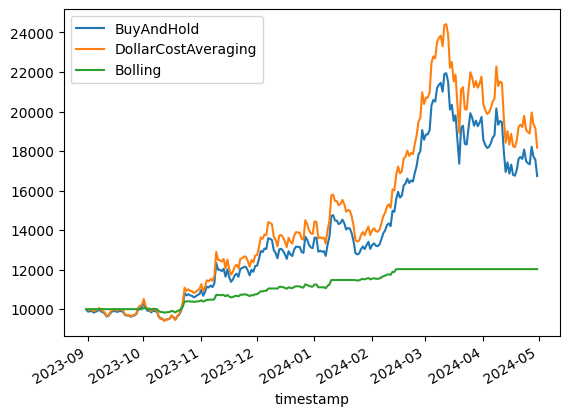

In [72]:
bt = cira.strategy.multi_strategy_backtest([cira.strategy.ByAndHold(), cira.strategy.DollarCostAveraging(1), strat], test_data, test_data["close"].to_frame(), 10_000)
print(f"Delta: {bt[strat.name].values[-1] - bt['BuyAndHold'].values[-1]:.2f}$")
bt.plot()